# Model 3: Improvement

The purpose of this model is to utilize reinforcement learning to improve the prediction capabilities of Model 2 

## Preliminary Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
import nbimporter
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### ACTOR Model Architecture

In [2]:
class Actor(nn.Module):
    
    def __init__(self, num_features):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) # Use ReLU
        x = self.fc2(x)
        return F.softmax(x, dim = -1)

### ACTOR Functions

In [3]:
def train_actor(model, optimizer, X_train, y_train, epochs):
    loss_list = []
    
    for epoch in range(epochs):
        optimizer.zero_grad() # Resets gradients
        outputs = model(X_train) # Forward Propagation
        loss = F.cross_entropy(outputs, y_train) # Calculate loss using cross-entropy
        loss.backward() # Backward Propagation
        optimizer.step() # Updates params
        
        loss_list.append(loss.item())
        
        print(f"Epoch {epoch}: Loss = {loss.item()}")
        
    return loss_list

In [4]:
def evaluate_actor(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)

    # Calculate train and test accuracy
    train_accuracy = accuracy_score(y_train, train_predicted)
    print(f'Train Accuracy: {train_accuracy}')
    
    test_accuracy = accuracy_score(y_test, test_predicted)
    print(f'Test Accuracy: {test_accuracy}')

    return train_accuracy, test_accuracy

In [59]:
def predict_action(model, X_input, valid):
    with torch.no_grad():
        output = model(X_input)
        
    valid_tensor = torch.tensor(valid, dtype = torch.bool)
    valid_output = torch.where(valid_tensor, output, torch.tensor(float('-inf')).to(output.dtype))
    
    random_choice = random.randint(1, 5)
    
    if random_choice == 1:
        _, predicted_action = torch.where(valid_output != float('-inf'))
        return np.random.choice(predicted_action).item()
    else:
        _, predicted_action = torch.max(valid_output, 1)
        return predicted_action.item()

In [6]:
def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

### Pretraining Data Preprocessing

In [7]:
pretrain_data = pd.read_csv('Data/Model1/Final/model1_data_raw.csv')

In [8]:
pretrain_data = pretrain_data.drop_duplicates()

In [9]:
X_pt = pretrain_data.iloc[:, :-1]
y_pt = pretrain_data.iloc[:, -1]

In [10]:
X_pt

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,crew_stay,alien_detected,crew_detected
0,10,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.001634,0.000000,0.001634,0.0,0,0
1,11,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.001758,0.0,0,1
2,12,9,0.0,0.0,0.0,0.0,0.0,0.001879,0.001879,0.000000,0.000000,0.0,0,1
3,12,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.001998,0.000000,0.000000,0.0,0,1
4,12,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.002111,0.000000,0.002111,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922400,21,10,0.0,0.0,0.0,0.0,0.0,0.015479,0.000000,0.009253,0.000000,0.0,0,1
4922401,21,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.011493,0.019962,0.0,0,1
4922402,22,9,0.0,0.0,0.0,0.0,0.0,0.020265,0.000000,0.000000,0.000000,0.0,0,1
4922412,21,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.016609,0.000000,0.0,0,1


In [11]:
y_pt

0          [0, 0, 0, 1, 0]
1          [0, 0, 0, 1, 0]
2          [1, 0, 0, 0, 0]
3          [1, 0, 0, 0, 0]
4          [1, 0, 0, 0, 0]
                ...       
4922400    [0, 1, 0, 0, 0]
4922401    [0, 0, 0, 1, 0]
4922402    [0, 1, 0, 0, 0]
4922412    [0, 0, 1, 0, 0]
4922413    [1, 0, 0, 0, 0]
Name: chosen_action, Length: 903605, dtype: object

In [12]:
X_pt = X_pt.drop(columns=['crew_stay'])

In [13]:
crew_columns = ['crew_up', 'crew_down', 'crew_left', 'crew_right']
X_pt['sum_crew'] = X_pt[crew_columns].sum(axis=1)

for col in crew_columns:
    X_pt.loc[X_pt['sum_crew'] != 0, col] = X_pt[col] / X_pt['sum_crew']

X_pt.drop('sum_crew', axis=1, inplace=True)

X_pt

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,alien_detected,crew_detected
0,10,9,0.0,0.0,0.0,0.0,0.0,0.00000,0.500000,0.000000,0.500000,0,0
1,11,9,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,1.000000,0,1
2,12,9,0.0,0.0,0.0,0.0,0.0,0.50000,0.500000,0.000000,0.000000,0,1
3,12,10,0.0,0.0,0.0,0.0,0.0,0.00000,1.000000,0.000000,0.000000,0,1
4,12,11,0.0,0.0,0.0,0.0,0.0,0.00000,0.500000,0.000000,0.500000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922400,21,10,0.0,0.0,0.0,0.0,0.0,0.62587,0.000000,0.374130,0.000000,0,1
4922401,21,9,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.365369,0.634631,0,1
4922402,22,9,0.0,0.0,0.0,0.0,0.0,1.00000,0.000000,0.000000,0.000000,0,1
4922412,21,9,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,1.000000,0.000000,0,1


In [14]:
y_pt = y_pt.apply(ast.literal_eval)
y_pt = y_pt.apply(lambda x: x.index(1))
y_pt

0          3
1          3
2          0
3          0
4          0
          ..
4922400    1
4922401    3
4922402    1
4922412    2
4922413    0
Name: chosen_action, Length: 903605, dtype: int64

In [15]:
X_pt_train, X_pt_test, y_pt_train, y_pt_test = train_test_split(X_pt, y_pt, test_size = 0.2, random_state = 42)

In [16]:
X_pt_train_tensor = torch.tensor(X_pt_train.values, dtype=torch.float32)
y_pt_train_tensor = torch.tensor(y_pt_train.values, dtype=torch.long)

X_pt_test_tensor = torch.tensor(X_pt_test.values, dtype=torch.float32)
y_pt_test_tensor = torch.tensor(y_pt_test.values, dtype=torch.long)

In [17]:
X_pt_train_tensor

tensor([[29.0000, 21.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [12.0000,  9.0000,  0.0000,  ...,  0.9938,  0.0000,  1.0000],
        [ 5.0000, 28.0000,  0.0000,  ...,  0.4924,  0.0000,  1.0000],
        ...,
        [11.0000, 10.0000,  0.0000,  ...,  0.0615,  0.0000,  1.0000],
        [25.0000, 26.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [18.0000,  0.0000,  0.0000,  ...,  0.4269,  0.0000,  1.0000]])

In [18]:
y_pt_train_tensor

tensor([2, 3, 0,  ..., 0, 1, 0])

### Initialize + Pretrain ACTOR

In [19]:
num_features = X_pt_train.shape[1]
actor = Actor(num_features)
optimizer = torch.optim.Adam(actor.parameters(), lr = 0.001) # Set learning rate to 0.001

In [20]:
loss_list = train_actor(actor, optimizer, X_pt_train_tensor, y_pt_train_tensor, epochs=500)

Epoch 0: Loss = 1.692863941192627
Epoch 1: Loss = 1.6759461164474487
Epoch 2: Loss = 1.6603995561599731
Epoch 3: Loss = 1.6470134258270264
Epoch 4: Loss = 1.6362440586090088
Epoch 5: Loss = 1.6280308961868286
Epoch 6: Loss = 1.6218905448913574
Epoch 7: Loss = 1.617202877998352
Epoch 8: Loss = 1.6134147644042969
Epoch 9: Loss = 1.6101200580596924
Epoch 10: Loss = 1.607050895690918
Epoch 11: Loss = 1.6040393114089966
Epoch 12: Loss = 1.600989580154419
Epoch 13: Loss = 1.597861647605896
Epoch 14: Loss = 1.5946511030197144
Epoch 15: Loss = 1.5913869142532349
Epoch 16: Loss = 1.5881215333938599
Epoch 17: Loss = 1.5849295854568481
Epoch 18: Loss = 1.581892490386963
Epoch 19: Loss = 1.579083800315857
Epoch 20: Loss = 1.5765607357025146
Epoch 21: Loss = 1.574357032775879
Epoch 22: Loss = 1.5724763870239258
Epoch 23: Loss = 1.5708922147750854
Epoch 24: Loss = 1.569554090499878
Epoch 25: Loss = 1.5683878660202026
Epoch 26: Loss = 1.5673067569732666
Epoch 27: Loss = 1.5662301778793335
Epoch 28: L

Epoch 227: Loss = 1.0834695100784302
Epoch 228: Loss = 1.0829744338989258
Epoch 229: Loss = 1.0824897289276123
Epoch 230: Loss = 1.0820146799087524
Epoch 231: Loss = 1.0815494060516357
Epoch 232: Loss = 1.081093192100525
Epoch 233: Loss = 1.0806459188461304
Epoch 234: Loss = 1.080207347869873
Epoch 235: Loss = 1.0797771215438843
Epoch 236: Loss = 1.0793547630310059
Epoch 237: Loss = 1.0789402723312378
Epoch 238: Loss = 1.0785332918167114
Epoch 239: Loss = 1.0781337022781372
Epoch 240: Loss = 1.0777415037155151
Epoch 241: Loss = 1.077355980873108
Epoch 242: Loss = 1.0769777297973633
Epoch 243: Loss = 1.0766061544418335
Epoch 244: Loss = 1.0762410163879395
Epoch 245: Loss = 1.0758816003799438
Epoch 246: Loss = 1.0755287408828735
Epoch 247: Loss = 1.0751817226409912
Epoch 248: Loss = 1.0748405456542969
Epoch 249: Loss = 1.0745047330856323
Epoch 250: Loss = 1.0741742849349976
Epoch 251: Loss = 1.073849081993103
Epoch 252: Loss = 1.0735291242599487
Epoch 253: Loss = 1.0732139348983765
Epoch

Epoch 450: Loss = 1.0458428859710693
Epoch 451: Loss = 1.0457706451416016
Epoch 452: Loss = 1.045699119567871
Epoch 453: Loss = 1.0456280708312988
Epoch 454: Loss = 1.0455572605133057
Epoch 455: Loss = 1.0454869270324707
Epoch 456: Loss = 1.0454164743423462
Epoch 457: Loss = 1.0453466176986694
Epoch 458: Loss = 1.0452768802642822
Epoch 459: Loss = 1.0452076196670532
Epoch 460: Loss = 1.0451388359069824
Epoch 461: Loss = 1.0450706481933594
Epoch 462: Loss = 1.0450023412704468
Epoch 463: Loss = 1.0449345111846924
Epoch 464: Loss = 1.0448670387268066
Epoch 465: Loss = 1.0447998046875
Epoch 466: Loss = 1.044732928276062
Epoch 467: Loss = 1.0446664094924927
Epoch 468: Loss = 1.0446003675460815
Epoch 469: Loss = 1.044534683227539
Epoch 470: Loss = 1.0444689989089966
Epoch 471: Loss = 1.0444036722183228
Epoch 472: Loss = 1.0443389415740967
Epoch 473: Loss = 1.0442742109298706
Epoch 474: Loss = 1.0442099571228027
Epoch 475: Loss = 1.044145941734314
Epoch 476: Loss = 1.0440821647644043
Epoch 47

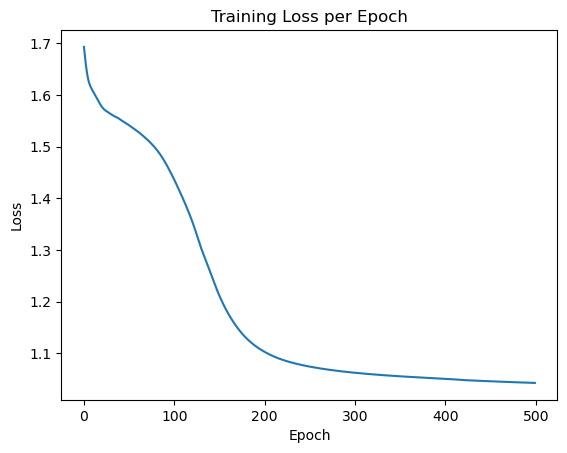

In [21]:
plot_loss(loss_list)

In [22]:
evaluate_actor(actor, X_pt_train_tensor, y_pt_train_tensor, X_pt_test_tensor, y_pt_test_tensor)

Train Accuracy: 0.8995481986044788
Test Accuracy: 0.8997128169941512


(0.8995481986044788, 0.8997128169941512)

## Simulate Bot1

In [23]:
import Bot1

In [24]:
file_name = 'Data/Model3/collected_data.csv'

In [25]:
%run Bot1.ipynb

In [26]:
grid, open_cells = create_grid() # Fixed grid orientation

In [27]:
def is_valid(x, y, move, grid, open_cells):
    if move == 'up' and (x, y + 1) in open_cells:
        return True
    elif move == 'down' and (x, y - 1) in open_cells:
        return True
    elif move == 'left' and (x - 1, y) in open_cells:
        return True
    elif move == 'right' and (x + 1, y) in open_cells:
        return True
    elif move == 'stay':
        return True
    else:
        return False

In [28]:
def predict_to_move(bot, prediction):
    next_move = bot
    
    if prediction == 0:
        next_move = (bot[0], bot[1] + 1)
    elif prediction == 1:
        next_move = (bot[0], bot[1] - 1)
    elif prediction == 2:
        next_move = (bot[0] - 1, bot[1])
    elif prediction == 3:
        next_move = (bot[0] + 1, bot[1])
    else:
        next_move = bot
        
    return next_move

In [29]:
def create_valid_matrix(X):
    global grid, open_cells
    directions = ['up', 'down', 'left', 'right', 'stay']
    valid_list = []
    for i in range(len(X)):
        x, y = X.iloc[i, 0], X.iloc[i, 1]
        validity_for_each_direction = [is_valid(x, y, move, grid, open_cells) for move in directions]
        valid_list.append(validity_for_each_direction)

    valid_array = np.array(valid_list)
    return valid_array

In [30]:
def determine_probabilities(bot, matrix):
    directions = {'up': (bot[0], bot[1] - 1), 
                  'down': (bot[0], bot[1] + 1), 
                  'left': (bot[0] - 1, bot[1]), 
                  'right': (bot[0] + 1, bot[1]),
                  'stay': bot}
    return [matrix.get(directions[direction], 0) for direction in ['up', 'down', 'left', 'right', 'stay']]

In [31]:
def predict_with_params(actor, bot, alien_matrix, crew_matrix, alien_detected, crew_detected):
    alien_probs = determine_probabilities(bot, alien_matrix)
    crew_probs = determine_probabilities(bot, crew_matrix)
    
    X = pd.DataFrame([{
        'bot_x': bot[0],
        'bot_y': bot[1],

        'alien_up': alien_probs[0],
        'alien_down': alien_probs[1],
        'alien_left': alien_probs[2],
        'alien_right': alien_probs[3],
        'alien_stay': alien_probs[4],

        'crew_up': crew_probs[0],
        'crew_down': crew_probs[1],
        'crew_left': crew_probs[2],
        'crew_right': crew_probs[3],

        'alien_detected': 1 if alien_detected else 0,
        'crew_detected': 1 if crew_detected else 0,
    }], columns=['bot_x', 'bot_y', 'alien_up', 'alien_down', 'alien_left', 'alien_right', 'alien_stay', 'crew_up', 'crew_down', 'crew_left', 'crew_right', 'alien_detected', 'crew_detected'])
    
    valid = create_valid_matrix(X)
    
    crew_columns = ['crew_up', 'crew_down', 'crew_left', 'crew_right']
    X['sum_crew'] = X[crew_columns].sum(axis=1)

    for col in crew_columns:
        X.loc[X['sum_crew'] != 0, col] = X[col] / X['sum_crew']

    X.drop('sum_crew', axis=1, inplace=True)
    
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    
    prediction = predict_action(actor, X_tensor, valid)
    next_move = predict_to_move(bot, prediction)
    
    return next_move

In [37]:
def Actor_Bot1(k, alpha, max_iter, timeout, actor):
    global grid, open_cells
    
    grid, open_cells = reset_grid(grid, open_cells)
    bot, ship, open_cells = place_bot(grid, open_cells)

    crew_list = []
    alien_list = []
    d_lookup_table = {}
    
    data_log = [] # Data Log Initialization

    crew_list, ship = place_crew(ship, open_cells, crew_list)
    alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

    alien_matrix = initialize_alienmatrix(open_cells, bot, k)
    crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
    
    alien_detected = False
    crew_detected = False

    win_count = 0
    loss_count = 0
    move = 0
    win_move_count = []
    marker = 0
    
    while (win_count + loss_count) < max_iter:
        neighbors = check_valid_neighbors(len(ship), bot[0], bot[1])
        open_moves = [neigh for neigh in neighbors if (grid[neigh] != 1)]
        open_moves.append(bot)
        next_move = predict_with_params(actor, bot, alien_matrix, crew_matrix, alien_detected, crew_detected) # Predict using trained network
        
        # Data Collection Process
        
        alien_probs = determine_probabilities(bot, alien_matrix)
        crew_probs = determine_probabilities(bot, crew_matrix)
        
        crew_probs.pop()
        
        if sum(crew_probs) > 0:
            crew_probs = [c / sum(crew_probs) for c in crew_probs]
        
        # Convert relative move to string      
        if next_move[0] > bot[0]:
            next_move_str = 'right'
        elif next_move[0] < bot[0]:
            next_move_str = 'left'
        elif next_move[1] > bot[1]:
            next_move_str = 'up'
        elif next_move[1] < bot[1]:
            next_move_str = 'down'
        else:
            next_move_str = 'stay'
        
        actions = {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'stay': 4}
        best_move_encoded = actions[next_move_str]
        
        log_entry = {
            'bot_x': bot[0],
            'bot_y': bot[1],
            
            'alien_up': alien_probs[0],
            'alien_down': alien_probs[1],
            'alien_left': alien_probs[2],
            'alien_right': alien_probs[3],
            'alien_stay': alien_probs[4],
            
            'crew_up': crew_probs[0],
            'crew_down': crew_probs[1],
            'crew_left': crew_probs[2],
            'crew_right': crew_probs[3],
            
            'alien_detected': 1 if alien_detected else 0,
            'crew_detected': 1 if crew_detected else 0,
            
            'chosen_action': best_move_encoded
        }
        data_log.append(log_entry)
        
        prev_win_count = win_count
        bot, crew_list, ship, open_cells, win_count, marker = move_bot(ship, bot, next_move, crew_list, alien_list, open_cells, win_count, 1)
        move += 1

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"ACTOR captured! Win Count: {win_count}, Loss Count: {loss_count}")

            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue

        if win_count > prev_win_count:
            print(f"Crew saved! Win Count: {win_count}, Loss Count: {loss_count}")
            win_move_count.append(move)
            move = 0
            d_lookup_table = {}
            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
        
        print(f"ACTOR: {bot}, Crew: {crew_list}, Aliens: {alien_list}")

        alien_matrix, crew_matrix = update_afterbotmove(bot, alien_matrix, crew_matrix)

        # Move bot to optimal neighbor
        marker, alien_list, ship = move_aliens(ship, alien_list, bot) # Move alien randomly

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"ACTOR captured! Win Count: {win_count}, Loss Count: {loss_count}")

            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue
        
        alien_matrix = update_afteralienmove(ship, alien_list, alien_matrix) # Update after alien move
        
        alien_detected = alien_sensor(alien_list, bot, k) # Run Alien Sensor
        crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Run Crew Sensor
        
        alien_matrix = update_alienmatrix(alien_matrix, alien_detected, bot, k) # Update based on alien sensor

        crew_matrix = update_crewmatrix(crew_matrix, crew_detected, d_lookup_table, bot, alpha) # Update based on crew sensor
        
    df = pd.DataFrame(data_log)
    df.to_csv(file_name, mode='w', index=False, header=True)

    return sum(win_move_count) // max(1, len(win_move_count)), (win_count / max(1, (win_count + loss_count))), win_count

In [38]:
def Actor_Bot1_Simulation(alpha_values, k_values, max_iter, timeout, num_simulations, actor):
    avg_rescue_moves_mbot1 = {k: [] for k in k_values}
    prob_crew_rescue_mbot1 = {k: [] for k in k_values}
    avg_crew_saved_mbot1 = {k: [] for k in k_values}

    for k in k_values:
        for alpha in alpha_values:
            total_metric1_mbot1, total_metric2_mbot1, total_metric3_mbot1 = 0, 0, 0
            
            for i in range(num_simulations):
                metric1_mbot1, metric2_mbot1, metric3_mbot1 = Actor_Bot1(k, alpha, max_iter, timeout, actor)

                total_metric1_mbot1 += metric1_mbot1
                total_metric2_mbot1 += metric2_mbot1
                total_metric3_mbot1 += metric3_mbot1

            avg_metric1_mbot1 = total_metric1_mbot1 / num_simulations
            avg_metric2_mbot1 = total_metric2_mbot1 / num_simulations
            avg_metric3_mbot1 = total_metric3_mbot1 / num_simulations

            print(f"ACTOR: k={k}, Alpha={alpha}\nAverage Rescue Moves={avg_metric1_mbot1}\nProbability of Crew Rescue={avg_metric2_mbot1}\nAverage Crew Saved={avg_metric3_mbot1}\n")
            
            avg_rescue_moves_mbot1[k].append(avg_metric1_mbot1)
            prob_crew_rescue_mbot1[k].append(avg_metric2_mbot1)
            avg_crew_saved_mbot1[k].append(avg_metric3_mbot1)

    return avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1

In [39]:
def test_simulation_actor(alpha_values, k_values, max_iter, timeout, num_simulations, actor):
    avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1 = Actor_Bot1_Simulation(alpha_values, k_values, max_iter, timeout, num_simulations, actor)

    prob_crew_rescue_mbot1 = {k: [round(prob, 3) for prob in probs] for k, probs in prob_crew_rescue_mbot1.items()}

    print(f"ACTOR:\nAverage Rescue Moves = {avg_rescue_moves_mbot1}\nProbability of Crew Rescue = {prob_crew_rescue_mbot1}\nAverage Crew Saved = {avg_crew_saved_mbot1}\n")
    
    return avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1

In [40]:
alpha_values = [0.004]
k_values = [3]
max_iter = 20
timeout = 10000
num_simulations = 10

In [58]:
metric1_mbot1, metric2_mbot1, metric3_mbot1 = test_simulation_actor(alpha_values, k_values, max_iter, timeout, num_simulations, actor)

ACTOR: (17, 14), Crew: [(23, 28)], Aliens: [(8, 9)]
ACTOR: (17, 13), Crew: [(23, 28)], Aliens: [(8, 9)]
ACTOR: (17, 14), Crew: [(23, 28)], Aliens: [(8, 9)]
ACTOR: (17, 14), Crew: [(23, 28)], Aliens: [(8, 9)]
ACTOR: (18, 14), Crew: [(23, 28)], Aliens: [(7, 9)]
ACTOR: (18, 14), Crew: [(23, 28)], Aliens: [(7, 9)]
ACTOR: (18, 13), Crew: [(23, 28)], Aliens: [(6, 9)]
ACTOR: (18, 12), Crew: [(23, 28)], Aliens: [(6, 9)]
ACTOR: (18, 11), Crew: [(23, 28)], Aliens: [(5, 9)]
ACTOR: (18, 10), Crew: [(23, 28)], Aliens: [(5, 9)]
ACTOR: (17, 10), Crew: [(23, 28)], Aliens: [(5, 9)]
ACTOR: (17, 10), Crew: [(23, 28)], Aliens: [(4, 9)]
ACTOR: (17, 9), Crew: [(23, 28)], Aliens: [(5, 9)]
ACTOR: (18, 9), Crew: [(23, 28)], Aliens: [(6, 9)]
ACTOR: (19, 9), Crew: [(23, 28)], Aliens: [(6, 8)]
ACTOR: (20, 9), Crew: [(23, 28)], Aliens: [(6, 9)]
ACTOR: (21, 9), Crew: [(23, 28)], Aliens: [(6, 9)]
ACTOR: (21, 10), Crew: [(23, 28)], Aliens: [(6, 8)]
ACTOR: (21, 9), Crew: [(23, 28)], Aliens: [(6, 8)]
ACTOR: (20, 9), Cr

ACTOR: (23, 27), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (23, 27), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (24, 27), Crew: [(11, 19)], Aliens: [(4, 10)]
ACTOR: (25, 27), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(4, 8)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(4, 6)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(4, 6)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(4, 8)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(4, 8)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (25, 28), Crew: [(11, 19)], Aliens: [(4, 10)]
ACTOR: (25, 29), Crew: [(11, 19)], Aliens: [(3, 10)]
ACTOR: (2

ACTOR: (23, 25), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (23, 25), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (23, 25), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (24, 25), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 8)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 9)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 8)]
ACTOR: (26, 25), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (25, 26), Crew: [(11, 19)], Aliens: [(2, 8)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (26, 25), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 6)]
ACTOR: (26, 25), Crew: [(11, 19)], Aliens: [(2, 6)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 6)]
ACTOR: (26, 25), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (26, 25), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (25, 25), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (26, 

ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (25, 19), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (25, 19), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(9, 13)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (27, 20), Crew: [(11, 19)], Aliens: [(9, 13)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (27, 20), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(9, 13)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(9, 13)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(9, 13)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(9, 13)]
ACTOR: (25, 19), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens

ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(7, 27)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(7, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(7, 25)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(7, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(7, 26)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(6, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 26)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 26)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(5, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 27)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(4, 27)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 27)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 28)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 28)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(5, 28)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(5, 27)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 27)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(5

ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 22)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(4, 22)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(3, 22)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2, 22)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2, 22)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(3, 22)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(4, 22)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(4, 22)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(3, 22)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(2, 22)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(3, 22)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(4, 22)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(3, 22)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(4, 22)]
ACTOR: (25, 19), Crew: [(11, 19)], Aliens: [(3, 22)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(2, 22)]
ACTOR: (25, 19), Crew: [(11, 19)], Aliens: [(3, 22)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(3, 22)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(3

ACTOR: (26, 17), Crew: [(11, 19)], Aliens: [(2, 25)]
ACTOR: (26, 16), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (27, 16), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (28, 16), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (27, 16), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (27, 15), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (27, 14), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (28, 14), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (28, 14), Crew: [(11, 19)], Aliens: [(2, 25)]
ACTOR: (28, 13), Crew: [(11, 19)], Aliens: [(2, 24)]
ACTOR: (28, 12), Crew: [(11, 19)], Aliens: [(2, 25)]
ACTOR: (28, 11), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (28, 10), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (27, 10), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (28, 10), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (27, 10), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (27, 9), Crew: [(11, 19)], Aliens: [(2, 27)]
ACTOR: (26, 9), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (27, 9), Crew: [(11, 19)], Aliens: [(3, 2

ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(2, 25)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(3, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 26)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2, 27)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(1, 27)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1, 28)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1, 27)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(0, 27)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(1, 27)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1, 28)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(1, 29)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1

ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(3, 14)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 14)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2, 13)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 13)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2, 12)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 11)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(2, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 11)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 11)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2, 12)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2, 12)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(2, 11)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(2, 12)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(2, 12)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(2, 13)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(2

ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(9, 18)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(8, 18)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(8, 17)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(7, 17)]
ACTOR: (27, 20), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (27, 20), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(6, 18)]
ACTOR: (27, 20), Crew: [(11, 19)], Aliens: [(5, 18)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(6, 18)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(7, 19)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(7, 17)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 16)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6

ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(6, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 18)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(5, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 18)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 18)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 18)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(7, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 18)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (29, 16), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (28, 16), Crew: [(11, 19)], Aliens: [(8, 18)]
ACTOR: (29, 16), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (29, 15), Crew: [(11, 19)], Aliens: [(6

ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1, 16)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 16)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(0, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 16)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 17)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(1, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(1, 18)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(1, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(1, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(0, 19)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0

ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(4, 22)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(4, 22)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 22)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(5, 23)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 23)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(5, 24)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(4, 24)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 24)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(5, 23)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 24)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(4, 24)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 24)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(4, 24)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(4, 25)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(4, 24)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(5, 24)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(5, 23)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(5, 24)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(4

ACTOR: (27, 17), Crew: [(11, 19)], Aliens: [(12, 21)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(12, 21)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(12, 21)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(12, 21)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(13, 20)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(13, 22)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(13, 22)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(12, 21)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(13, 21)]
ACTOR: (29, 18), Crew: [(11,

ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(9, 14)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(11, 15)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(11, 15)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(11, 15)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(11, 15)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (29, 18), Crew: [(11, 19

ACTOR: (29, 16), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(11, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(10, 11)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(11, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(10, 11)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(11, 11)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(11, 11)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(10, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(10, 10)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(10, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(9, 11)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(9, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(10, 11)]
ACTOR: (29, 17), Crew: [(11, 1

ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(1, 21)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1, 21)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(1, 20)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1, 20)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1, 20)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(1, 19)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(1, 20)]
ACTOR: (29, 16), Crew: [(11, 19)], Aliens: [(1, 19)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(1, 18)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(1, 19)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 19)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(0, 19)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(0, 18)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(0

ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(5, 16)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 16)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 16)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(6, 16)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(7, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(8, 17)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(7, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(6, 16)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(6, 17)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(7, 17)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(7, 18)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(8, 18)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(9, 18)]
ACTOR: (29, 16), Crew: [(11, 19)], Aliens: [(10, 18)]
ACTOR: (29, 15), Crew: [(11, 19)], Aliens: [(10, 18)]
ACTOR: (29, 16), Crew: [(11, 19)], Aliens: [(10, 18)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: 

ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(19, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(16, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(18, 5)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 6)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(18, 6)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 6)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(17, 6)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(1

ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(20, 9)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(20, 9)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(20, 9)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(21, 9)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(20, 9)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(19, 9)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(19, 8)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(19, 9)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 9)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 9)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(18, 9)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 9)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(19, 9)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(19, 9)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(19, 10)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 10)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(19, 10)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(18, 10)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens:

ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(20, 11)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(20, 12)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(20, 13)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(19, 13)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(20, 13)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(20, 14)]
ACTOR: (27, 17), Crew: [(11, 19)], Aliens: [(20, 15)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(19, 15)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(20, 15)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(20, 14)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(20, 15)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(20, 14)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(20, 15)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(19, 15)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(19, 15)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(19, 15)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(18, 15)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(19, 15)]
ACTOR: (27, 19), Crew: [(11,

ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(20, 6)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(21, 6)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(22, 6)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(22, 6)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(21, 6)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(21, 5)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(21, 4)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(21, 4)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(21, 5)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(21, 5)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(21, 6)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(21, 5)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(21, 5)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(21, 4)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(21, 5)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(21, 6)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(21, 6)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(21, 5)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(2

ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(26, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(26, 4)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(25, 4)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(25, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(25, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(25, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(26, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(27, 4)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(27, 4)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(27, 4)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(27, 4)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(27, 4)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (29, 16), Crew: [(11, 19)], Aliens: [(2

ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(29, 2)]
ACTOR: (29, 16), Crew: [(11, 19)], Aliens: [(28, 2)]
ACTOR: (29, 17), Crew: [(11, 19)], Aliens: [(28, 2)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(28, 2)]
ACTOR: (29, 19), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (29, 18), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (28, 18), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (27, 18), Crew: [(11, 19)], Aliens: [(29, 1)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(29, 2)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(29, 3)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(29, 2)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(29, 3)]
ACTOR: (27, 20), Crew: [(11, 19)], Aliens: [(29, 4)]
ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(29, 3)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(29, 3)]
ACTOR: (25, 19), Crew: [(11, 19)], Aliens: [(29, 4)]
ACTOR: (24, 19), Crew: [(11, 19)], Aliens: [(29, 3)]
ACTOR: (25, 19), Crew: [(11, 19)], Aliens: [(29, 2)]
ACTOR: (24, 19), Crew: [(11, 19)], Aliens: [(2

ACTOR: (27, 19), Crew: [(11, 19)], Aliens: [(29, 1)]
ACTOR: (26, 19), Crew: [(11, 19)], Aliens: [(29, 1)]
ACTOR: (25, 19), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (25, 20), Crew: [(11, 19)], Aliens: [(28, 2)]
ACTOR: (24, 20), Crew: [(11, 19)], Aliens: [(29, 2)]
ACTOR: (25, 20), Crew: [(11, 19)], Aliens: [(29, 1)]
ACTOR: (24, 20), Crew: [(11, 19)], Aliens: [(29, 1)]
ACTOR: (24, 21), Crew: [(11, 19)], Aliens: [(29, 1)]
ACTOR: (23, 21), Crew: [(11, 19)], Aliens: [(29, 1)]
ACTOR: (23, 20), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (23, 21), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (23, 22), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (24, 22), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (24, 22), Crew: [(11, 19)], Aliens: [(28, 1)]
ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(28, 2)]
ACTOR: (26, 22), Crew: [(11, 19)], Aliens: [(27, 2)]
ACTOR: (26, 23), Crew: [(11, 19)], Aliens: [(27, 2)]
ACTOR: (27, 23), Crew: [(11, 19)], Aliens: [(2

ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (26, 22), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (26, 22), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (26, 22), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (26, 22), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (26, 22), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(16, 3)]
ACTOR: (25, 22), Crew: [(11, 19)], Aliens: [(16, 3)]
ACTOR: (24, 22), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (24, 21), Crew: [(11, 19)], Aliens: [(17, 2)]
ACTOR: (23, 21), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (23, 21), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (23, 22), Crew: [(11, 19)], Aliens: [(19, 3)]
ACTOR: (23, 21), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (24, 21), Crew: [(11, 19)], Aliens: [(1

ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(27, 4)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(27, 4)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(27, 4)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(26, 3)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(26, 2)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(26, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(27, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(26, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(26, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(26, 2)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(27, 2)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(26, 2)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(26, 3)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(26, 4)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(2

ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(21, 1)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(21, 2)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(21, 1)]
ACTOR: (25, 28), Crew: [(11, 19)], Aliens: [(21, 2)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(21, 2)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(21, 1)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(21, 0)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(21, 1)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(22, 1)]
ACTOR: (25, 27), Crew: [(11, 19)], Aliens: [(22, 1)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(22, 1)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(21, 1)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(22, 1)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(23, 1)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(23, 1)]
ACTOR: (25, 27), Crew: [(11, 19)], Aliens: [(24, 1)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(24, 1)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(24, 2)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(2

ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(16, 3)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(16, 3)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(16, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(17, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(18, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(18, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(18, 6)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(18, 6)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(18, 6)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(17, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(17, 6)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(1

ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(19, 3)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(19, 2)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(19, 3)]
ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(19, 4)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(19, 4)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(19, 4)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(19, 4)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(20, 4)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(20, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(19, 3)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(19, 4)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(18, 5)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(18, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(18, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(18, 4)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(18, 5)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(18, 6)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(1

ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(14, 7)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(14, 6)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(13, 6)]
ACTOR: (25, 28), Crew: [(11, 19)], Aliens: [(14, 6)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(14, 6)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(14, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(14, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(14, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(14, 6)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(14, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(13, 6)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(13, 6)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(13, 6)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(13, 6)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(13, 6)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(14, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(14, 6)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(13, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(1

ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(14, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(13, 13)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(13, 13)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(11, 13)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(11, 15)]
ACTOR: (28, 29), Crew: [(11,

ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(7, 11)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 11)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(7, 11)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 11)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(7, 12)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(7, 13)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(7, 13)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 12)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 12)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 13)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(6, 13)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(6, 12)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(7, 12)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 13)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(7, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(7, 11)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(7, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(7, 13)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(7

ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 10)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 10)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(5, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 9)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(5, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 9)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(4, 8)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(4, 8)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(4, 10)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(4, 10)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(4, 8)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(4, 8)]
ACTOR: (

ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(6, 10)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(6, 10)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 10)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(6, 10)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 8)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 8)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(5, 9)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (

ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(2, 6)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(2, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(0, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(0, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(0, 5)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (29, 

ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(5, 9)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(8, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(8, 10)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(9, 10)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(8, 10)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(8, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(8, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 9)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(4, 9)]
ACTOR: (2

ACTOR: (25, 27), Crew: [(11, 19)], Aliens: [(11, 5)]
ACTOR: (25, 27), Crew: [(11, 19)], Aliens: [(10, 5)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(10, 6)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(10, 5)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(10, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(10, 6)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(10, 6)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(10, 6)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(10, 7)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(10, 6)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(10, 6)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(10, 5)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(10, 5)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(10, 6)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(10, 5)]
ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(11, 5)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(12, 5)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(11, 5)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(1

ACTOR: (29, 24), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (29, 24), Crew: [(11, 19)], Aliens: [(14, 12)]
ACTOR: (29, 24), Crew: [(11, 19)], Aliens: [(15, 12)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(14, 12)]
ACTOR: (28, 25), Crew: [(11, 19)], Aliens: [(14, 12)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (28, 25), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (28, 25), Crew: [(11, 19)], Aliens: [(11, 13)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (28, 25), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(10, 14)]
ACTOR: (29, 24), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(11, 15)]
ACTOR: (28, 25), Crew: [(11, 19)], Aliens: [(11, 15)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(12, 15)]
ACTOR: (28, 25), Crew: [(11, 19)], Aliens: [(11, 15)]
ACTOR: (29, 25), Crew: [(11,

ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(11, 13)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(11, 14)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(11, 13)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(11, 13)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(13, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(12, 12)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(11, 12)]
ACTOR: (28, 29), Crew: [(11,

ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(2, 6)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(2, 8)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(4, 6)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (27, 

ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (25, 28), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (26, 28), Crew: [(11, 19)], Aliens: [(2, 6)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(2, 8)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(2, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(2, 8)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(2, 9)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(2, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(2, 8)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(2, 9)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(2, 8)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(2, 6)]
ACTOR: (27, 

ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(2, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(5, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(5, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(6, 8)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 7)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 8)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 8)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(6, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 5)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(7, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(7, 5)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(7, 6)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(7, 6)]
ACTOR: (28, 

ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(9, 10)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(9, 10)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(9, 10)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(9, 11)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(9, 10)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(9, 11)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(10, 11)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(10, 11)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(10, 10)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(9, 10)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(10, 10)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(9, 10)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(8, 10)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(8, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 9)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(8, 9)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(8, 10)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(8, 10)]
ACTOR: (26, 27), Crew: [(11, 19)], Aliens: [(

ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(8, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(7, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(7, 5)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(6, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 6)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(7, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(5, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(3, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(5, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 6)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (28, 

ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(5, 5)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(4, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(3, 5)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(3, 4)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(3, 5)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(3, 4)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(3, 4)]
ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(3, 5)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(4, 5)]
ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(5, 5)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(5, 5)]
ACTOR: (28, 25), Crew: [(11, 19)], Aliens: [(6, 5)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(6, 6)]
ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(6, 5)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(6, 5)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 6)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(6, 7)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(5, 7)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(4, 7)]
ACTOR: (28, 

ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 1)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(5, 1)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(6, 1)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(6, 0)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(6, 0)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 0)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 1)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(5, 1)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 1)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(7, 1)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(7, 2)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(7, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 3)]
ACTOR: (28, 

ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(7, 3)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(6, 3)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(7, 3)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(7, 4)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(7, 5)]
ACTOR: (27, 28), Crew: [(11, 19)], Aliens: [(7, 5)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(7, 5)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(7, 4)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(7, 5)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(7, 4)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(7, 5)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(6, 5)]
ACTOR: (27, 29), Crew: [(11, 19)], Aliens: [(5, 5)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(5, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(6, 5)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(5, 5)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(6, 5)]
ACTOR: (27, 27), Crew: [(11, 19)], Aliens: [(5, 5)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(4, 5)]
ACTOR: (29, 

ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(0, 5)]
ACTOR: (29, 25), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (29, 26), Crew: [(11, 19)], Aliens: [(0, 5)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(0, 5)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (28, 27), Crew: [(11, 19)], Aliens: [(0, 6)]
ACTOR: (29, 27), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (29, 28), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(0, 7)]
ACTOR: (28, 29), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (28, 28), Crew: [(11, 19)], Aliens: [(1, 7)]
ACTOR: (29, 

KeyboardInterrupt: 